# Simplified Custom Object Detection
**Name: Mihalyi Geza**
**Neptun ID: IL1VCP**
**Network: Own created**
**Objects: ClipArtStatue, StoneObject, WaterStone**


# 0. Import the Dependencies

In [2]:
#Here are the selected imports

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from icrawler.builtin import GoogleImageCrawler
import matplotlib.image as mpimg
import os
from random import randrange
import cv2
import random
from PIL import Image
import json
from pathlib import Path
import torch
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

from torchvision.transforms import v2
from torchvision.io import decode_image, read_file
from torchvision import tv_tensors
from matplotlib.patches import Rectangle
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from zipfile import ZipFile
torch.manual_seed(1)
import shutil



# 1. Dataset creation

### 1.1 Download the images

In [3]:
#Download Some Background image - create the directory
directory = 'background'
if not os.path.exists(directory):
    os.makedirs(directory)

In [3]:
#Download the images - we download 200 images all together
google_crawler = GoogleImageCrawler(
    parser_threads=2,
    downloader_threads=4,
    storage={'root_dir': 'background'}
)

for keyword in ['Las Vegas', 'Burj al arab', 'Seychelles', 'Azores', 'Canary islands', 'Budapest', 'Castle', 'Park', "Balaton", 'Porto']:
    google_crawler.crawl(
        keyword=keyword, max_num=20, file_idx_offset='auto')

2024-10-25 22:01:00,597 - INFO - icrawler.crawler - start crawling...
2024-10-25 22:01:00,598 - INFO - icrawler.crawler - starting 1 feeder threads...
2024-10-25 22:01:00,599 - INFO - feeder - thread feeder-001 exit
2024-10-25 22:01:00,601 - INFO - icrawler.crawler - starting 2 parser threads...
2024-10-25 22:01:00,603 - INFO - icrawler.crawler - starting 4 downloader threads...
2024-10-25 22:01:01,684 - INFO - parser - parsing result page https://www.google.com/search?q=Las+Vegas&ijn=0&start=0&tbs=&tbm=isch
2024-10-25 22:01:02,120 - ERROR - downloader - Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/LV_Valley_montage.jpg
2024-10-25 22:01:02,176 - INFO - downloader - image #1	https://dynamic-media-cdn.tripadvisor.com/media/photo-o/2a/34/2d/28/caption.jpg
2024-10-25 22:01:02,358 - INFO - downloader - image #2	https://media.cnn.com/api/v1/images/stellar/prod/180313182911-01-las-vegas-travel-strip.jpg
2024-10-25 22:01:02,385 - INFO - downloader - 

KeyboardInterrupt: 

2024-10-25 22:01:04,058 - INFO - downloader - image #7	https://travelnevada.com/wp-content/uploads/2020/09/Vegas_Featured.jpg


2024-10-25 22:01:04,575 - INFO - downloader - image #8	https://i.natgeofe.com/n/a3da17ad-c5d4-47c0-b207-40b78611743a/weblasvegasgettyimages-642330128hr.jpg
2024-10-25 22:01:04,659 - INFO - downloader - image #9	https://cdn.britannica.com/64/94464-050-72D80A30/Casinos-Strip-Las-Vegas-Nev.jpg
2024-10-25 22:01:04,687 - INFO - downloader - image #10	https://fly-over-the-world-media.s3.amazonaws.com/uploads/highlights/63bedc4e3340f-63bee1587af2e_1280_720.jpg
2024-10-25 22:01:05,293 - INFO - downloader - image #11	https://static.independent.co.uk/2024/07/24/12/newFile-7.jpg
2024-10-25 22:01:06,621 - INFO - downloader - image #12	https://upload.wikimedia.org/wikipedia/commons/5/5e/Welcome_to_Fabulous_Las_Vegas.jpg
2024-10-25 22:01:06,790 - INFO - downloader - image #13	https://content.r9cdn.net/rimg/dimg/0a/9e/073516d2-city-35107-1656d23229c.jpg
2024-10-25 22:01:06,894 - INFO - downloader - image #14	https://cdn.aarp.net/content/dam/aarp/travel/destinations/2022/03/1140-las-vegas-sign.jpg
202

### 1.2 Unzip the Objects

In [3]:
zipdata = ZipFile('UsableObjects.zip')
zipdata.extractall()

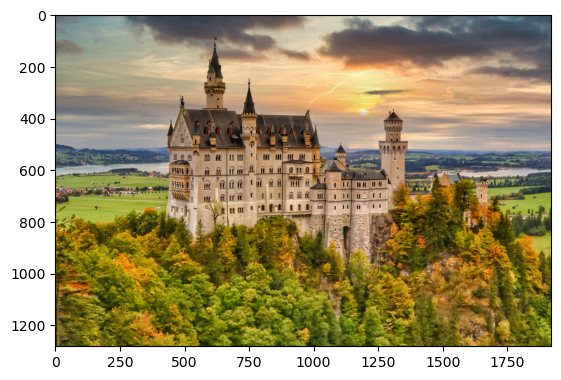

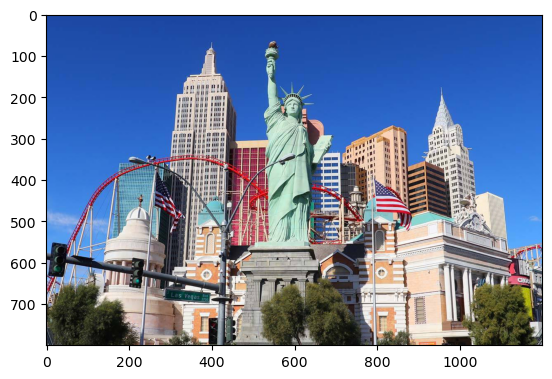

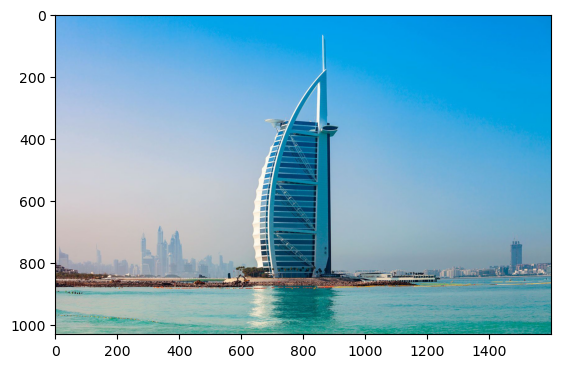

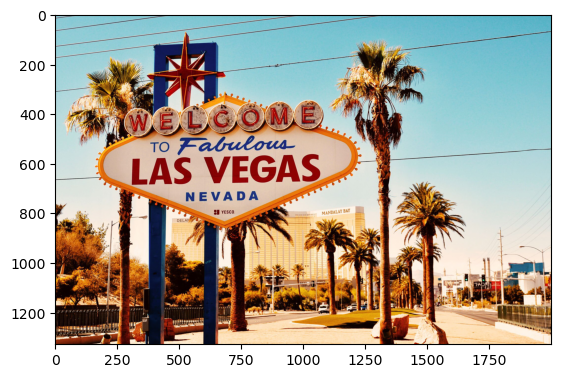

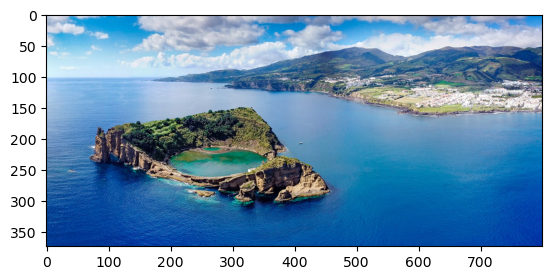

In [4]:

ImageNames = os.listdir(directory)


def display_sample_images(directory: str, ImageName: str) -> None:
    image = mpimg.imread(f"{directory}\\{ImageName}")
    plt.figure()
    plt.imshow(image)

#This is going to show 5 random pictures
for i in range(5):
    randomNumber = randrange(len(ImageNames))
    display_sample_images(directory, ImageNames[randomNumber])

### 1.3 Add the objects to the background and save them

In [5]:

def GenerateIamgesandBoundingBoxes(ImageNames: list):
    #We create a folder for the New Images
    ObjBGPath = "OBJBG"
    if not os.path.exists(ObjBGPath):
        os.makedirs(ObjBGPath)
    OBJBGPic = "Images"
    if not os.path.exists(f"{ObjBGPath}\\{OBJBGPic}"):
        os.makedirs(f"{ObjBGPath}\\{OBJBGPic}")
    OBJBGBounding = "BoundingBox"
    if not os.path.exists(f"{ObjBGPath}\\{OBJBGBounding}"):
        os.makedirs(f"{ObjBGPath}\\{OBJBGBounding}")


    ObjectDirectory = 'Object'
    #Gather all the names of the objects
    ObjectNames = os.listdir(ObjectDirectory)

    #We suffle the list of background 
    random.shuffle(ImageNames)

    ObjectID = {
        ObjectNames[0] : 0,
        ObjectNames[1] : 1,
        ObjectNames[2] : 2
    }


    for i in ImageNames:
        #Open the images
        BackgroundImage = Image.open(f"{directory}\\{i}")
        
        #We choose a random Statue
        randomStatue = randrange(len(ObjectNames))
        StatueImage = Image.open(f"{ObjectDirectory}\\{ObjectNames[randomStatue]}")

        #We get the Image Size and scale them down randomly
        w, h = StatueImage.size
        bgw, bgh = BackgroundImage.size
        randomScaleNumber = round(random.uniform(0.1, 0.4), 2)
        StatueImage.thumbnail((w*randomScaleNumber, h*randomScaleNumber))

        #We resize the Image to be smaller and for every image to be the same size
        BackgroundImage = BackgroundImage.resize((320, 320))

        #We get the now Modified Statue and BG size
        bgw, bgh = BackgroundImage.size
        w, h = StatueImage.size

        #We define some random start points in the BG where we will insert the files
        randomPlaceonBGWidth = random.randint(0, bgw-w)
        randomPlaceonBGHeight = random.randint(0, bgh-h)


        #We Paste the images to the BG
        BackgroundImage.paste(StatueImage, (randomPlaceonBGWidth,randomPlaceonBGHeight), StatueImage.convert('RGBA'))
        class_id = ObjectID[ObjectNames[randomStatue]]

        #This is for Pytorch tv_tensors._bounding_boxis 'CXCYWH' format
        x_center = int(randomPlaceonBGWidth + (w / 2))
        y_center = int(randomPlaceonBGHeight + (h / 2))
        width = w
        height = h
        BoundingBox = {
            "class_id": class_id,
            "x_center": x_center,
            "y_center": y_center,
            "width": width,
            "height": height
        }

        

        open_cv_image = np.array(BackgroundImage)
        #To convert RGB to BGR
        try:
            open_cv_image = open_cv_image[:, :, ::-1].copy()

            with open(f"{ObjBGPath}\\{OBJBGBounding}\\{i[:-4]}.json", "w") as output:
                json.dump(BoundingBox, output, indent=4)
            cv2.imwrite(f"{ObjBGPath}\\{OBJBGPic}\\{i[:-4]}.jpg", open_cv_image)
        except:
            print(f"This picture is png: {i}")





In [6]:
GenerateIamgesandBoundingBoxes(ImageNames)

This picture is png: 000044.png
This picture is png: 000106.png


### 1.4 Create images with random transformations
Here we create random transformed images and save them to the directory

In [7]:
def GenerateTrainValTest(numImages: int, PathofImages: list, PathofBB = list) -> None:

    PATHPic = 'OBJBG//Images'
    PATHBoundingBox = 'OBJBG//BoundingBox'

    # Where to output the images
    BasePath = "root//dataset//"
    if not os.path.exists(BasePath):
        os.makedirs(BasePath)
    
    OutPathIm = os.path.join(BasePath, "all_image//images")
    OutPathBB = os.path.join(BasePath, "all_image//labels")
    if not os.path.exists(OutPathIm):
        os.makedirs(OutPathIm)
    if not os.path.exists(OutPathBB):
        os.makedirs(OutPathBB)
        
    filename = "all_images"
    
    numberofimages = len(PathofImages)
    NumberAugIm = int(numImages / numberofimages)  # Number of augmented images per input image
    ProcessImageNumber = 0

    for i in range(numberofimages):
        # Load image and bounding box
        useImage = os.path.join(PATHPic, PathofImages[i])
        useBB = os.path.join(PATHBoundingBox, PathofBB[i])

        # Load image
        img_path = Path(useImage)
        img = decode_image(read_file(img_path))

        # Load bounding box
        with open(useBB, 'r') as file:
            BoundingBox = json.load(file)

        boxes = tv_tensors.BoundingBoxes(
            [[BoundingBox['x_center'], BoundingBox['y_center'], BoundingBox['width'], BoundingBox['height']]],  # Format: [center_x, center_y, width, height]
            format='CXCYWH',
            canvas_size=(img.shape[1], img.shape[2])  # Canvas size is (height, width)
        )

        for j in range(NumberAugIm):
            transforms = v2.Compose([
                v2.ToDtype(torch.float32, scale=True),
                v2.RandomHorizontalFlip(p=0.5),
                v2.RandomVerticalFlip(p=0.5),
                v2.GaussianBlur(random.randrange(1, 4, 2))
            ])

            out_img, out_boxes = transforms(img, boxes)

            for box in out_boxes:
                x_center, y_center, width, height = box

            # Convert to YOLO format
            xYolo = x_center / img.shape[2]
            yYolo = y_center / img.shape[1]
            widthYolo = width / img.shape[2]
            heightYolo = height / img.shape[1]

            YoloString = f"{BoundingBox['class_id']} {xYolo.item():.6f} {yYolo.item():.6f} {widthYolo.item():.6f} {heightYolo.item():.6f}"

            # Convert tensor image to NumPy, scale to [0, 255], and convert to uint8
            out_img_np = out_img.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
            out_img_np = (out_img_np * 255).astype('uint8')  # Ensure data type and scaling for OpenCV

            # Write the YOLO annotation
            with open(f"{OutPathBB}\\{filename}{ProcessImageNumber:05d}.txt", "w") as outputYOLO:
                outputYOLO.write(YoloString)

            # Write the image using OpenCV
            cv2.imwrite(f"{OutPathIm}\\{filename}{ProcessImageNumber:05d}.jpg", out_img_np)

            ProcessImageNumber += 1





### 1.5 Sort the images
We sort the images to train, val, test

In [8]:

def SortingImages(TypeData, imagelist, yololist):
    #Where to output the images
    BasePath = "root\\dataset\\"
    if not os.path.exists(BasePath):
        os.makedirs(BasePath)
    match TypeData:
        case "train":
            OutPathIm = os.path.join(BasePath,"train\\images")
            OutPathBBYOLO = os.path.join(BasePath,"train\\labels")
            if not os.path.exists(OutPathIm):
                os.makedirs(OutPathIm)
            if not os.path.exists(OutPathBBYOLO):
                os.makedirs(OutPathBBYOLO)
            filename = "train"
        case "val":
            OutPathIm = os.path.join(BasePath,"val\\images")
            OutPathBBYOLO = os.path.join(BasePath,"val\\labels")
            if not os.path.exists(OutPathIm):
                os.makedirs(OutPathIm)
            if not os.path.exists(OutPathBBYOLO):
                os.makedirs(OutPathBBYOLO)
            filename = "val"
        case "test":
            OutPathIm = os.path.join(BasePath,"test\\images")
            OutPathBBYOLO = os.path.join(BasePath,"test\\labels")
            if not os.path.exists(OutPathIm):
                os.makedirs(OutPathIm)
            if not os.path.exists(OutPathBBYOLO):
                os.makedirs(OutPathBBYOLO)
            filename = "test"
    for i in imagelist:
        imorig = cv2.imread(f"{BasePath}\\all_image\\images\\{i}")
        cv2.imwrite(f"{OutPathIm}\\{i}", imorig)
    
    for h in yololist:
        shutil.copyfile(f"{BasePath}\\all_image\\labels\\{h}", f"{OutPathBBYOLO}\\{h}")
    

In [9]:
#Generate the Test, Train, Val datasets, with x, y, z images in each
GenImPath = "OBJBG\Images"
GenBBPath = "OBJBG\BoundingBox"



GeneratedImages = os.listdir(GenImPath)
GeneratedBB = os.listdir(GenBBPath)

GenerateTrainValTest(numImages=3000, PathofImages=GeneratedImages, PathofBB=GeneratedBB)

AllImagePath = "root\\dataset\\all_image\\images"
AllImageBB = "root\\dataset\\all_image\\labels"


AllImages = os.listdir(AllImagePath)
AllBB = os.listdir(AllImageBB)
zipped = list(zip(AllImages, AllBB))


#Shuffle all the files and create a train, val, test dataset in 0.8, 0.2, 0.1 ratio 
random.shuffle(zipped)
AllImages, AllBB = zip(*zipped)

TrainIm = AllImages[:int(len(AllImages)*0.7)]
TrainBB = AllBB[:int(len(AllBB)*0.7)]

ValIm = AllImages[int(len(AllImages)*0.7):int(len(AllImages)*0.9)]
ValBB = AllBB[int(len(AllBB)*0.7):int(len(AllBB)*0.9)]

TestIm = AllImages[int(len(AllImages)*0.9):]
TestBB = AllBB[int(len(AllBB)*0.9):]


SortingImages("train", TrainIm, TrainBB)
SortingImages("val", ValIm, ValBB)
SortingImages("test", TestIm, TestBB)



### 1.6 Create Pytorch Dataset

In [5]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.label_dir = os.path.join(root_dir, 'labels')
        self.image_filenames = os.listdir(self.image_dir)
        self.transform = transform  # Default to ToTensor if no transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Load the image safely using PIL and convert to RGB
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None


        #This is for Yolo
        label_name = img_name.replace('.jpg', '.txt')

        label_path = os.path.join(self.label_dir, label_name)

        #This isfor YOLO
        with open(label_path, 'r') as YoloData:
            line = YoloData.readline().strip()
            values = line.split()
            class_id = int(values[0])
            x_center = float(values[1])
            y_center = float(values[2])
            width = float(values[3])
            height = float(values[4])

        bbox = [
                x_center,
                y_center,
                width,
                height
            ]
        # Apply any transformations on the image (if specified)
        if self.transform:
            image = self.transform(image)

        # Return image and label as a dictionary
        return {
            'image': image,
            'label': torch.tensor(class_id, dtype=torch.long),
            'bbox': torch.tensor(bbox, dtype=torch.float32)  # normalized bbox
        }
  



In [6]:
#Check if cpu or gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 2. Create the CNN

In [32]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

class CustomObjectDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomObjectDetectionModel, self).__init__()
        # Define layers (same as before)
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.bbox_regressor = nn.Sequential(
            # nn.AdaptiveAvgPool2d((1, 1)),
            # nn.Flatten(),
            nn.Linear(320, 128),
            nn.BatchNorm2d(3),
            nn.Flatten(),
            nn.ELU(),
            nn.Linear(122880, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Tanh(),

            nn.Linear(128,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256,512),

            nn.LeakyReLU(),

            nn.Linear(512, 4)  # Output: (x_center, y_center, width, height)
        )
        self.transform = transforms.Compose([
            transforms.Resize((320, 320)),
            transforms.ToTensor(),  # Convert image to tensor
        ])

    def forward(self, x):
        features = self.features(x)
        class_logits = self.classifier(features)
        bbox_regression = self.bbox_regressor(x)
        return class_logits, bbox_regression

    def predict(self, image_path, device='cpu', class_labels=None):
        # Load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        original_image = image.copy()  # Save the original image for drawing
        image = self.transform(image).unsqueeze(0).to(device)
        
        # Set the model to evaluation mode
        self.eval()
        
        with torch.no_grad():
            # Forward pass
            class_logits, bbox_regression = self.forward(image)
        
        # Get predicted class and bounding box
        class_probs = torch.softmax(class_logits, dim=1)
        predicted_class = torch.argmax(class_probs, dim=1).item()
        predicted_class_prob = class_probs[0, predicted_class].item()
        predicted_bbox = bbox_regression[0].cpu().numpy()  # (x_center, y_center, width, height)

        x_center, y_center, width, height = predicted_bbox

        return {
            'class_id': predicted_class,
            'class_prob': predicted_class_prob,
            'bbox': [x_center, y_center, width, height]
        }


### 2.1 Train the model

### 2.1.1 IOU loss

In [8]:
    # Convert boxes from [xmin, ymin, width, height] to [xmin, ymin, xmax, ymax]
def convert_to_corners(boxes):
        """
            Convert boxes from [xmin, ymin, width, height] to [xmin, ymin, xmax, ymax].
        """
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]  # xmax = xmin + width
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]  # ymax = ymin + height
        return boxes

def calculate_iou(box1, box2):
        """
            Manually calculates the IoU (Intersection over Union) between two bounding boxes.
            Each box is represented by [xmin, ymin, xmax, ymax].
        """
        # Determine the coordinates of the intersection rectangle
        inter_xmin = max(box1[0], box2[0])
        inter_ymin = max(box1[1], box2[1])
        inter_xmax = min(box1[2], box2[2])
        inter_ymax = min(box1[3], box2[3])

        # Compute the area of the intersection rectangle
        inter_width = max(inter_xmax - inter_xmin, 0)
        inter_height = max(inter_ymax - inter_ymin, 0)
        inter_area = inter_width * inter_height

        # Compute the area of both the predicted and true rectangles
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

        # Compute the union area
        union_area = box1_area + box2_area - inter_area

        # Compute IoU
        iou = inter_area / union_area if union_area > 0 else 0.0
        return iou


def iou_loss(pred_boxes, true_boxes, img_width=320, img_height=320):
        """
        IoU Loss: 1 - IoU (since IoU is a value between 0 and 1, minimizing 1 - IoU will maximize IoU).
        Both pred_boxes and true_boxes should be in absolute coordinates [xmin, ymin, xmax, ymax].
        """
        # Create copies of the boxes to avoid in-place modification
        pred_boxes_scaled = pred_boxes.clone()
        true_boxes_scaled = true_boxes.clone()

    # Convert normalized bounding boxes to absolute pixel values (if applicable)
        pred_boxes_scaled[:, [0, 2]] *= img_width  # Convert x coordinates
        pred_boxes_scaled[:, [1, 3]] *= img_height  # Convert y coordinates
        true_boxes_scaled[:, [0, 2]] *= img_width  # Convert x coordinates
        true_boxes_scaled[:, [1, 3]] *= img_height  # Convert y coordinates

        # Apply the conversion to both predicted and true boxes
        pred_boxes_converted = convert_to_corners(pred_boxes_scaled)
        true_boxes_converted = convert_to_corners(true_boxes_scaled)

        ious = []
        for i in range(len(pred_boxes_converted)):
            pred_box = pred_boxes_converted[i]
            true_box = true_boxes_converted[i]
            iou = calculate_iou(pred_box, true_box)
            ious.append(iou)
        #print(f"IoU for predicted box {i}: {iou:.4f}")

    # Convert list of IoUs to a tensor and compute the mean for IoU loss
        iou_tensor = torch.tensor(ious, device=pred_boxes.device)
        iou_loss_value = 1 - iou_tensor.mean()

        return iou_loss_value, ious


In [9]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Function to calculate accuracy
def calculate_accuracy(logits, labels):
    _, predicted_classes = torch.max(logits, 1)
    correct = (predicted_classes == labels).sum().item()
    accuracy = correct / labels.size(0)  # Correct predictions divided by the total number of labels
    return accuracy

# Define training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001, device='cuda'):
    # Move the model to the correct device (GPU/CPU)
    model = model.to(device)
    
    # Define optimizer and loss functions
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    classification_loss_fn = nn.CrossEntropyLoss()
    bbox_loss_fn = nn.SmoothL1Loss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_accuracy = 0.0
        train_regression_losses = []
        IOUlist = []

        # Iterate over the training data
        for batch in tqdm(train_loader):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            bboxes = batch['bbox'].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            class_logits, bbox_regression = model(images)

            # Remove extra dimension from bbox_list if present
            bboxes = torch.squeeze(bboxes, dim=1)

            # Calculate losses
            classification_loss = classification_loss_fn(class_logits, labels)
            bbox_loss = bbox_loss_fn(bbox_regression, bboxes)
            iou_loss_value, iouvalues = iou_loss(bbox_regression, bboxes)


            # Total loss is a weighted sum of classification and bbox regression loss
            allregressionloss = 0.1*bbox_loss + 0.9*iou_loss_value
            loss = classification_loss*0.1 + allregressionloss*0.9

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            batch_accuracy = calculate_accuracy(class_logits, labels)
            total_accuracy += batch_accuracy

            for i in iouvalues:
                IOUlist.append(i)

        avg_loss = running_loss / len(train_loader)
        avg_accuracy = total_accuracy / len(train_loader)
        avgIOU = sum(IOUlist)/len(IOUlist)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy*100:.2f}%, Average IOU: {avgIOU:.2f}")

        # Optionally, validate the model after each epoch
        validate_model(model, val_loader, device)

# Validation function (with accuracy)
def validate_model(model, val_loader, device):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    IOUlist = []
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            bboxes = batch['bbox'].to(device)

            # Forward pass
            class_logits, bbox_regression = model(images)

            # Calculate validation losses
            classification_loss = nn.CrossEntropyLoss()(class_logits, labels)
            bbox_loss = nn.SmoothL1Loss()(bbox_regression, bboxes)
            iou_loss_value, iouvalues = iou_loss(bbox_regression, bboxes)


            allregressionloss = 0.1*bbox_loss + 0.9*iou_loss_value
            loss = classification_loss*0.1 + allregressionloss*0.9

            total_loss += loss.item()

            # Calculate accuracy
            batch_accuracy = calculate_accuracy(class_logits, labels)
            total_accuracy += batch_accuracy

            for i in iouvalues:
                IOUlist.append(i)

    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader)
    avgIOU = sum(IOUlist)/len(IOUlist)
    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {avg_accuracy*100:.2f}%, Validation Avg IOU: {avgIOU:.2f}")



### 2.2 Visualize some images

In [10]:
def visualize_dataset(dataset, numberofimages):
    ObjectDirectory = 'Object'  
    #Gather all the names of the objects
    ObjectNames = os.listdir(ObjectDirectory)

    #We suffle the list of background 
    random.shuffle(ImageNames)

    ObjectID = {
        0: ObjectNames[0][:-4],
        1: ObjectNames[1][:-4],
        2: ObjectNames[2][:-4]
    }

    

    for i in range(numberofimages):
        imagenumber = random.randint(0, len(dataset)-1)
        sample = dataset[imagenumber]
        image = sample['image']
        classid = sample['label'].item()
        classname = ObjectID[classid]

        image = image.permute(1, 2, 0).numpy()
        x_center, y_center, width, height = sample['bbox']


        x_center = x_center*image.shape[0]
        y_center = y_center*image.shape[1]
        width = width*image.shape[0]
        height = height*image.shape[1] 

        #get the start Coordinates
        x_min = x_center - (width/2)
        y_min = y_center - (height/2)
        
        fig, ax = plt.subplots(1)
        ax.imshow(image)
        rect = Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
        ax.add_patch(rect)
        plt.title(f"Sample: {imagenumber}, Class: {classname}")
        plt.show()


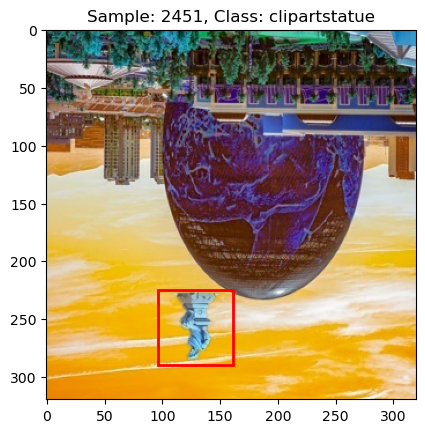

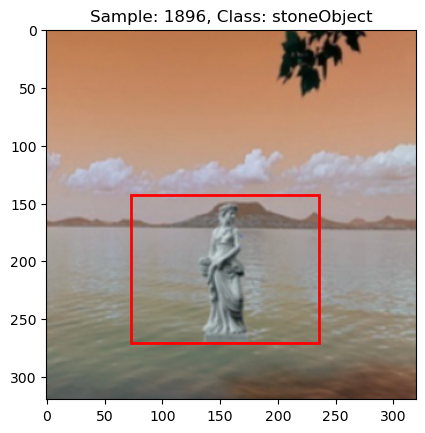

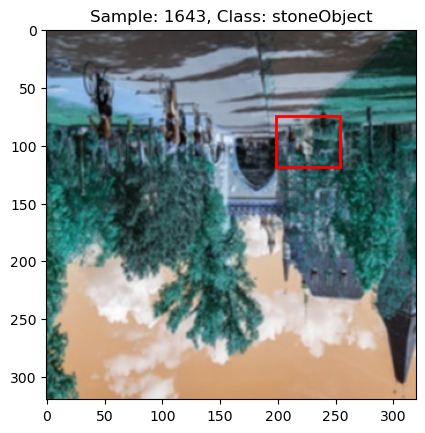

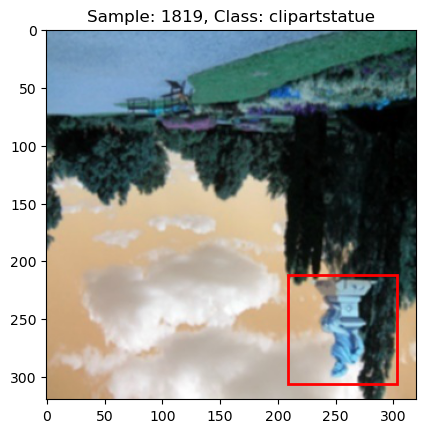

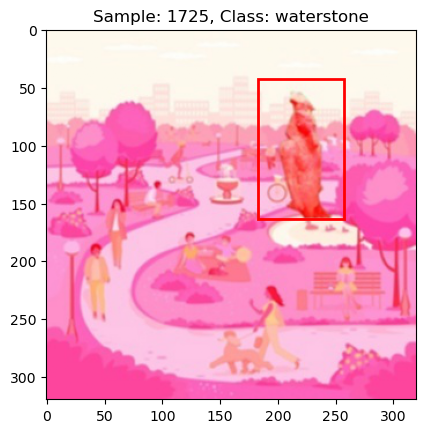

In [11]:
# Assuming you've already defined your DataLoader
transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),  # Convert image to tensor
])

train_dataset = ImageDataset(root_dir='root\\dataset\\train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=False)

val_dataset = ImageDataset(root_dir='root\\dataset\\val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=False)

visualize_dataset(train_dataset, 5)


In [33]:
# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

num_classes = 3  # Update based on your number of classes
model = CustomObjectDetectionModel(num_classes)
#visualize_dataset(train_dataset, 5)


train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001, device=device)
#torch.save(model.state_dict(), 'model_weights_new_coordinate.pth')

cuda


100%|██████████| 169/169 [00:22<00:00,  7.36it/s]


Epoch [1/20], Loss: 0.8186, Accuracy: 41.61%, Average IOU: 0.12
Validation Loss: 1.0659, Validation Accuracy: 43.18%


100%|██████████| 169/169 [00:23<00:00,  7.32it/s]


Epoch [2/20], Loss: 0.7834, Accuracy: 48.48%, Average IOU: 0.16
Validation Loss: 1.0791, Validation Accuracy: 43.20%


100%|██████████| 169/169 [00:22<00:00,  7.36it/s]


Epoch [3/20], Loss: 0.7607, Accuracy: 52.63%, Average IOU: 0.18
Validation Loss: 0.9897, Validation Accuracy: 49.57%


100%|██████████| 169/169 [00:22<00:00,  7.42it/s]


Epoch [4/20], Loss: 0.7350, Accuracy: 57.21%, Average IOU: 0.20
Validation Loss: 0.9967, Validation Accuracy: 55.45%


100%|██████████| 169/169 [00:22<00:00,  7.45it/s]


Epoch [5/20], Loss: 0.7209, Accuracy: 60.72%, Average IOU: 0.21
Validation Loss: 1.0692, Validation Accuracy: 49.48%


100%|██████████| 169/169 [00:22<00:00,  7.42it/s]


Epoch [6/20], Loss: 0.6995, Accuracy: 64.02%, Average IOU: 0.23
Validation Loss: 0.7614, Validation Accuracy: 64.27%


100%|██████████| 169/169 [00:22<00:00,  7.36it/s]


Epoch [7/20], Loss: 0.6827, Accuracy: 68.16%, Average IOU: 0.24
Validation Loss: 0.8390, Validation Accuracy: 61.70%


100%|██████████| 169/169 [00:23<00:00,  7.15it/s]


Epoch [8/20], Loss: 0.6694, Accuracy: 70.56%, Average IOU: 0.26
Validation Loss: 0.6646, Validation Accuracy: 68.24%


100%|██████████| 169/169 [00:23<00:00,  7.06it/s]


Epoch [9/20], Loss: 0.6471, Accuracy: 73.08%, Average IOU: 0.28
Validation Loss: 0.8337, Validation Accuracy: 63.00%


100%|██████████| 169/169 [00:23<00:00,  7.18it/s]


Epoch [10/20], Loss: 0.6326, Accuracy: 76.04%, Average IOU: 0.29
Validation Loss: 0.6045, Validation Accuracy: 75.38%


100%|██████████| 169/169 [00:22<00:00,  7.45it/s]


Epoch [11/20], Loss: 0.6187, Accuracy: 77.88%, Average IOU: 0.30
Validation Loss: 0.4909, Validation Accuracy: 80.41%


100%|██████████| 169/169 [00:22<00:00,  7.42it/s]


Epoch [12/20], Loss: 0.6034, Accuracy: 80.99%, Average IOU: 0.31
Validation Loss: 0.4125, Validation Accuracy: 85.35%


100%|██████████| 169/169 [00:22<00:00,  7.45it/s]


Epoch [13/20], Loss: 0.5902, Accuracy: 83.10%, Average IOU: 0.32
Validation Loss: 0.4598, Validation Accuracy: 80.07%


100%|██████████| 169/169 [00:22<00:00,  7.39it/s]


Epoch [14/20], Loss: 0.5767, Accuracy: 83.80%, Average IOU: 0.34
Validation Loss: 0.7595, Validation Accuracy: 72.82%


100%|██████████| 169/169 [00:22<00:00,  7.45it/s]


Epoch [15/20], Loss: 0.5804, Accuracy: 84.21%, Average IOU: 0.33
Validation Loss: 0.4201, Validation Accuracy: 83.38%


100%|██████████| 169/169 [00:22<00:00,  7.45it/s]


Epoch [16/20], Loss: 0.5595, Accuracy: 87.09%, Average IOU: 0.35
Validation Loss: 0.7209, Validation Accuracy: 74.53%


100%|██████████| 169/169 [00:22<00:00,  7.47it/s]


Epoch [17/20], Loss: 0.5504, Accuracy: 88.57%, Average IOU: 0.36
Validation Loss: 0.3990, Validation Accuracy: 84.14%


100%|██████████| 169/169 [00:22<00:00,  7.43it/s]


Epoch [18/20], Loss: 0.5400, Accuracy: 89.28%, Average IOU: 0.37
Validation Loss: 0.4091, Validation Accuracy: 84.69%


100%|██████████| 169/169 [00:23<00:00,  7.33it/s]


Epoch [19/20], Loss: 0.5266, Accuracy: 89.83%, Average IOU: 0.38
Validation Loss: 0.6131, Validation Accuracy: 75.78%


100%|██████████| 169/169 [00:23<00:00,  7.32it/s]


Epoch [20/20], Loss: 0.5304, Accuracy: 91.35%, Average IOU: 0.38
Validation Loss: 0.2632, Validation Accuracy: 90.21%


Accuracy on test set: 0.90 
Precision: 0.9099, Recall: 0.9079, mAP: 0.9306


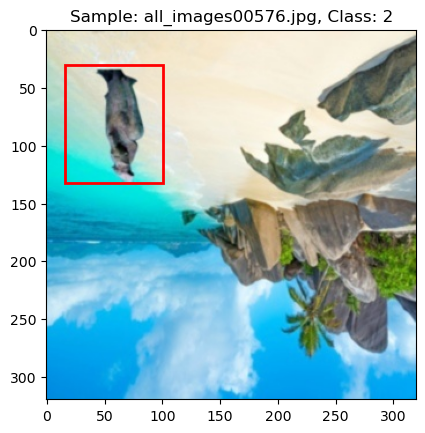

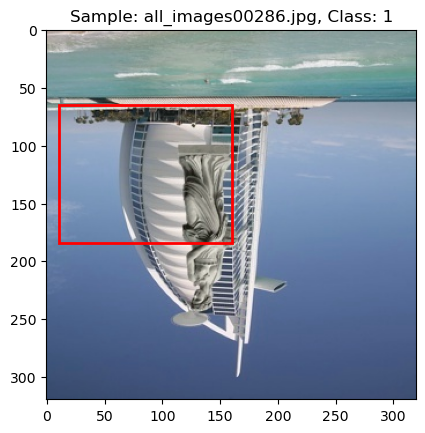

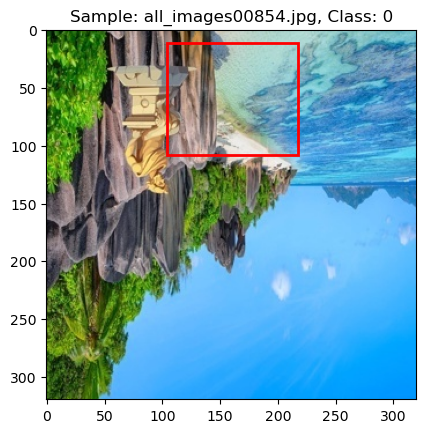

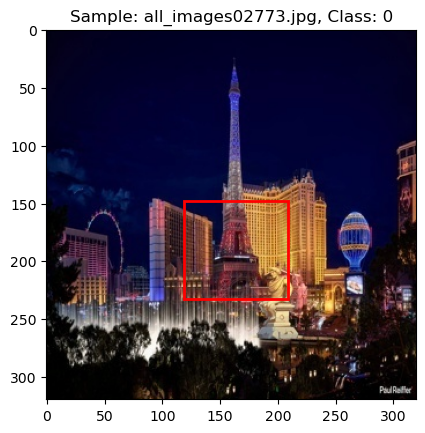

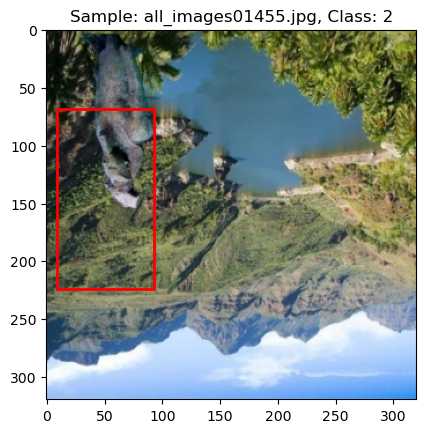

In [34]:
#Test accuracy
#model = CustomObjectDetectionModel(3)
#model.load_state_dict(torch.load('model_weights_new_coordinate.pth'))

TestPath = "root\\dataset\\test\\images"
TestPathBB = "root\\dataset\\test\\labels"

TestImages = os.listdir(TestPath)
TestBB = os.listdir(TestPathBB)
# Move model to appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Set the model to evaluation mode
model.eval()


correctimages = 0

all_targets = []
all_predictions = []
# Predict on a new image
for i in range(len(TestImages)):
    image_path = f'root/dataset/test/images/{TestImages[i]}'


    #This is CXCYWH
    # with open(f'root/dataset/test/labels/{TestBB[i]}', 'r') as file:
    #     data = json.load(file)
    # realclass = data["class_id"]

    #This is YOLO format
    with open(f'root/dataset/test/labels/{TestBB[i]}', 'r') as YoloData:
            line = YoloData.readline().strip()
            values = line.split()
            realclass = int(values[0])
    

    prediction = model.predict(image_path, device=device)
    
    all_predictions.append(prediction["class_id"])
    all_targets.append(realclass)
    if prediction["class_id"] == realclass:
        correctimages += 1
# Output the prediction
precision = precision_score(all_targets, all_predictions, average='macro', zero_division=1)
recall = recall_score(all_targets, all_predictions, average='macro')
all_targets_binary = label_binarize(all_targets, classes=np.unique(all_targets))
all_predictions_binary = label_binarize(all_predictions, classes=np.unique(all_predictions))
mAP = roc_auc_score(all_targets_binary, all_predictions_binary, average='macro', multi_class='ovr')
testaccuracy = correctimages/len(TestImages)
print(f"Accuracy on test set: {testaccuracy:.2f} ")
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, mAP: {mAP:.4f}')


for i in range(5):
    image = random.choice(TestImages)
    image_path = f'root/dataset/test/images/{image}'
    imagecv2 = cv2.imread(image_path)
    prediction = model.predict(image_path, device=device)
    x_center, y_center, width, height = prediction['bbox']

    x_center = x_center*imagecv2.shape[0]
    y_center = y_center*imagecv2.shape[1]
    width = width*imagecv2.shape[0]
    height = height*imagecv2.shape[1] 

    x_min = x_center - (width/2)
    y_min = y_center - (height/2)
    
    fig, ax = plt.subplots(1)
    ax.imshow(imagecv2)
    rect = Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
    ax.add_patch(rect)
    plt.title(f"Sample: {image}, Class: {prediction['class_id']}")
    plt.show()


### 3. YOLO Object detection

In [35]:
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
import torch
import os
print(f"Setup complete. Using torch {torch.__version__} on device ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Ultralytics 8.3.7  Python-3.11.9 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
Setup complete  (16 CPUs, 31.2 GB RAM, 265.9/466.1 GB disk)
Setup complete. Using torch 2.4.1 on device (NVIDIA GeForce RTX 4050 Laptop GPU)


In [36]:
path_train_im = 'root/dataset/train/images/'
path_train_bb = 'root/dataset/train/labels/'
path_val_im = 'root/dataset/val/images/'
path_val_bb = 'root/dataset/val/labels/'
path_test_im = 'root/dataset/test/images/'
path_test_bb = 'root/dataset/test/labels/'

#Check file lengt
testim = os.listdir(path_test_im)
testbb = os.listdir(path_test_bb)

valimg = os.listdir(path_val_im)
valbb = os.listdir(path_val_bb)

trainim = os.listdir(path_train_im)
trainbb = os.listdir(path_train_bb)

assert len(testim) == len(testbb)
assert len(valimg) == len(valbb)
assert len(trainim) == len(trainbb)


print(len(trainim))
print(len(trainbb))
res=[]
for file in os.listdir(path_train_im):
    if file.endswith('.jpg'):
        res.append(path_train_im+file)
with open('train.txt', 'w') as f:
    for line in res:
        f.write(line)
        f.write('\n')
f.close()

res=[]
for file in os.listdir(path_val_im):
    if file.endswith('.jpg'):
        res.append(path_val_im+file)
with open('val.txt', 'w') as f:
    for line in res:
        f.write(line)
        f.write('\n')
f.close()

res=[]
for file in os.listdir(path_test_im):
    if file.endswith('.jpg'):
        res.append(path_test_im+file)
with open('test.txt', 'w') as f:
    for line in res:
        f.write(line)
        f.write('\n')
f.close()



2692
2692


In [37]:
with open('./NewDataset.yaml', 'w') as f:

        f.write("path:  \ntrain: train.txt \nval: val.txt \ntest: test.txt \n")
        f.write("nc: 3 \n")
        f.write("names:\n  0: ClipArtStatue\n  1: StoneObject\n  2: WaterStone")
        f.write('\n')
f.close()

In [38]:
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
model = YOLO('yolov8n.yaml')
results=model.train(data="NewDataset.yaml", epochs=10, imgsz=320, batch=16, project="Labor", name="Test")

Ultralytics 8.3.7  Python-3.11.9 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
Setup complete  (16 CPUs, 31.2 GB RAM, 265.9/466.1 GB disk)
New https://pypi.org/project/ultralytics/8.3.23 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.7  Python-3.11.9 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=NewDataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=Labor, name=Test, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source

100%|██████████| 5.35M/5.35M [00:00<00:00, 6.27MB/s]
c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\torch_utils.py:261: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:185.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\torch_utils.py:266: UserWarning: Deterministic behavior was enabled with either `torch

AMP: checks passed 


train: Scanning root\dataset\train\labels... 2692 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2692/2692 [00:01<00:00, 2129.42it/s]


train: New cache created: root\dataset\train\labels.cache


val: Scanning root\dataset\val\labels... 1069 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1069/1069 [00:00<00:00, 1688.81it/s]


val: New cache created: root\dataset\val\labels.cache
Plotting labels to Labor\Test\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to Labor\Test
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/169 [00:00<?, ?it/s]c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       1/10      5.14G      2.854       4.19      3.934          4        320: 100%|██████████| 169/169 [00:21<00:00,  7.76it/s]
                 Class     I

                   all       1069       1069      0.418      0.181     0.0978     0.0369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/169 [00:00<?, ?it/s]c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       2/10      1.82G      2.202      2.848      2.856          4        320: 100%|██████████| 169/169 [00:16<00:00, 10.32it/s]
                 Class     I

                   all       1069       1069      0.537      0.259      0.348      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/169 [00:00<?, ?it/s]c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       3/10      1.82G      1.775      1.863      2.413          4        320: 100%|██████████| 169/169 [00:15<00:00, 10.79it/s]
                 Class     I

                   all       1069       1069      0.613      0.754        0.8      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/169 [00:00<?, ?it/s]c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       4/10      1.82G      1.507      1.404      2.121          4        320: 100%|██████████| 169/169 [00:15<00:00, 10.95it/s]
                 Class     I

                   all       1069       1069      0.853      0.832      0.915      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/169 [00:00<?, ?it/s]c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       5/10      1.82G      1.347      1.201      1.945          4        320: 100%|██████████| 169/169 [00:15<00:00, 11.00it/s]
                 Class     I

                   all       1069       1069      0.909      0.907      0.955       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/169 [00:00<?, ?it/s]c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       6/10      1.81G      1.189      1.004      1.789          4        320: 100%|██████████| 169/169 [00:15<00:00, 10.61it/s]
                 Class     I

                   all       1069       1069      0.956      0.924      0.976      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/169 [00:00<?, ?it/s]c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       7/10      1.82G      1.094     0.8891      1.692          4        320: 100%|██████████| 169/169 [00:16<00:00, 10.43it/s]
                 Class     I

                   all       1069       1069      0.975      0.964      0.983      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/169 [00:00<?, ?it/s]c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       8/10      1.82G      1.018      0.813      1.598          4        320: 100%|██████████| 169/169 [00:16<00:00, 10.42it/s]
                 Class     I

                   all       1069       1069      0.976      0.972      0.987      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/169 [00:00<?, ?it/s]c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
       9/10      1.82G     0.9408     0.7498      1.517          4        320: 100%|██████████| 169/169 [00:16<00:00, 10.49it/s]
                 Class     I

                   all       1069       1069       0.99      0.974      0.991      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/169 [00:00<?, ?it/s]c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\loss.py:202: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:185.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
      10/10      1.81G     0.8737     0.6948      1.463          4        320: 100%|██████████| 169/169 [00:15<00:00, 10.67it/s]
                 Class     I

                   all       1069       1069      0.993      0.977      0.992      0.863



10 epochs completed in 0.069 hours.
Optimizer stripped from Labor\Test\weights\last.pt, 5.6MB
Optimizer stripped from Labor\Test\weights\best.pt, 5.6MB

Validating Labor\Test\weights\best.pt...
WARNING  validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.7  Python-3.11.9 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
YOLOv8n summary (fused): 186 layers, 2,684,953 parameters, 0 gradients, 6.8 GFLOPs


c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\torch_utils.py:261: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:185.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\torch_utils.py:266: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context:

                   all       1069       1069       0.99      0.974      0.991      0.867
         ClipArtStatue        386        386      0.997      0.971      0.988      0.884
           StoneObject        344        344      0.981      0.971      0.992      0.837
            WaterStone        339        339      0.992      0.979      0.993       0.88
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to Labor\Test


In [39]:
results = model.predict(source=image_path, imgsz= 320, conf=0.100, iou=0.3, save = True)

c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\torch_utils.py:261: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\Context.cpp:185.)
  fusedconv.weight.copy_(torch.mm(w_bn, w_conv).view(fusedconv.weight.shape))
c:\Users\msi\anaconda3\envs\ELTE\Lib\site-packages\ultralytics\utils\torch_utils.py:266: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context:

image 1/1 c:\Users\msi\Documents\ELTE\DeepNetworkDevelompent\Assignment1\root\dataset\test\images\all_images01455.jpg: 320x320 1 WaterStone, 39.9ms
Speed: 2.0ms preprocess, 39.9ms inference, 7.7ms postprocess per image at shape (1, 3, 320, 320)
Results saved to Labor\Test2


In [59]:
# plot on local machine
for r in results:
    im_array = r.cpu().numpy().plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image

In [40]:
testresults = model.val()  # Run validation/test to measure accuracy and mAP

WARNING  validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.7  Python-3.11.9 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)


val: Scanning root\dataset\val\labels.cache... 1069 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1069/1069 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 67/67 [00:05<00:00, 12.11it/s]


                   all       1069       1069       0.99      0.974      0.991      0.867
         ClipArtStatue        386        386      0.997      0.971      0.988      0.884
           StoneObject        344        344      0.981      0.971      0.992      0.836
            WaterStone        339        339      0.992      0.979      0.993      0.879
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to Labor\Test3


# 3. Comparison

I did not have time to visualize the differences.

But the YOLO outperformed my model in every possible scenario. For the Precision and Recall and mAP I could have created a better more by training it for more epochs. But for the IoU i just did not find the right neural network. While the boxes for the YOLO has a high percent of IoU, for my model, I do not really reach the 60%. I spent too much time on it, probably most of the time in the wrong place, that is why I could not show predections on the same image.

I compared the my last predicted image on the YOLO Architecture, and it classified it 97% for the correct object and it managed to get the Bounding box right. It can be seen in the Labor/Test2